Импортируем необходимые библиотеки:

In [1]:
import cv2
import os
import time

import numpy as np
import matplotlib.pyplot as plt

Для сопоставления точек на кадрах будем использовать анализ движения при помощи фазовой корреляции:

In [2]:
def points_matching(image_1, image_2, points_1, points_2, eps=3):
    '''
    Функция сопоставления особых точек двух изображений.
    :param image_1: первое изображение
    :param image_2: второе изображение
    :param src_image: особые точки первого изображения
    :param src_image: особые точки второго изображения
    :param eps: погрешность при сопоставлении точек после сдвига
    :return: два массива, содержащие номера особых точек первого/второго изображения,
             отсутствующих на другом изображении
    '''
    image_1 = image_1.astype(np.float64)
    image_2 = image_2.astype(np.float64)
    shift = np.array(cv2.phaseCorrelate(image_1, image_2)[0])
    
    missing_1 = np.ones(len(points_1))
    missing_2 = np.ones(len(points_2))
    for i, point_1 in enumerate(points_1):
        for j, point_2 in enumerate(points_2):
            if ((point_1 - point_2 + shift) ** 2).sum() < eps ** 2:
                missing_1[i] = missing_2[j] = 0
        
    return np.nonzero(missing_1), np.nonzero(missing_2)

Напишем также функцию, строющую график зависимости воспроизводимости детекторов от номера кадра:

In [3]:
def get_repeatability(frames, detector, params):
    '''
    Функция нахождения воспроизводимости детектора для каждого кадра.
    :param frames: массив соседних кадров
    :param detector: детектор для нахождения особых точек
    :param params: параметры детектора
    :return: массив со значениями воспроизводимости детектора для каждого кадра
    '''
    keypoints_array = []
    for frame in frames:
        keypoints = detector(frame, **params)
        if isinstance(keypoints, tuple):
            keypoints = keypoints[0]
            keypoints = [np.array(keypoint.pt) for keypoint in keypoints]
        else:
            keypoints = [keypoint[0] for keypoint in keypoints]
        keypoints_array.append(keypoints)
        
    repeatability = [np.full(len(keypoints), len(frames) - 1) for keypoints in keypoints_array]
    for i in range(len(frames)):
        for j in range(i):
            missing_1, missing_2 = points_matching(frames[i], frames[j],
                                                   keypoints_array[i], keypoints_array[j])
            repeatability[i][missing_1] -= 1
            repeatability[j][missing_2] -= 1
            
    # усредняем по всем точкам для каждого каждра
    repeatability = [(rep / (len(frames) - 1)).mean() for rep in repeatability]
    
    return np.array(repeatability)

def show_repeatability(frames, detectors, params, names):
    '''
    Функция, строющая график зависимости воспроизводимости детекторов от номера кадра.
    :param frames: массив соседних кадров
    :param detectors: детекторы для нахождения особых точек
    :param params: массив параметров детектора
    :param names: названия детекторов
    :return: None
    '''
    plt.figure(figsize=(12, 7))
    
    for detector, param, name in zip(detectors, params, names):
        repeatability = get_repeatability(frames, detector, param)
        plt.plot(np.arange(len(frames)), repeatability * 100, label=name)
    
    plt.title('Зависимость значения воспроизводимости детектора от номера кадра')
    plt.xlabel('Номер кадра')
    plt.ylabel('Значение воспроизводимости (в %)')
    plt.legend()
    plt.grid(True)
    plt.show()

Считываем изображения и подсчитываем требуемые значения воспроизводимости для детекторов Shi-Tomasi, SURF и ORB:

In [4]:
images = []
for image_name in os.listdir('images'):
    image = cv2.imread(os.path.join('images', image_name))
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

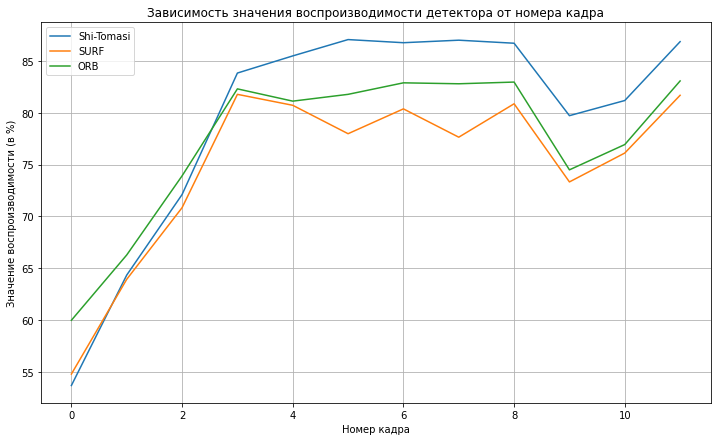

In [5]:
surf = cv2.xfeatures2d.SIFT_create(500, 8)
orb = cv2.ORB_create(nlevels=4)

detectors = [cv2.goodFeaturesToTrack, surf.detectAndCompute, orb.detectAndCompute]
params = [
    {'maxCorners': 650, 'qualityLevel': 0.3, 'minDistance': 1},
    {'mask': None,},
    {'mask': None,}
]
names = ['Shi-Tomasi', 'SURF', 'ORB']

show_repeatability(images, detectors=detectors, params=params, names=names)

Подсчитаем время работы каждого детектора на одну особую точку:

In [6]:
times = {}
for detector, detector_params, name in zip(detectors, params, names):
    start_time = time.time()
    keypoints = detector(images[0], **detector_params)
    times[name] = time.time() - start_time
    if isinstance(keypoints, tuple):
        keypoints = keypoints[0]
    times[name] /= len(keypoints)

In [7]:
for name, avg_time in times.items():
    print(f'{name}: {int(avg_time * 1e6)} микросекунд на особую точку')

Shi-Tomasi: 18 микросекунд на особую точку
SURF: 132 микросекунд на особую точку
ORB: 10 микросекунд на особую точку


**Вывод:** Таким образом, среди рассмотренных детекторов Shi-Tomasi показывает самые высокие значения воспроизводимости на большинстве кадров. Скорее всего, это объясняется тем, что в тексте встречается достаточно много уголков и все они хорошо определяются этим детектором. При этом для особых точек центральных кадров воспроизводимость выше на всех детекторах. Можно также отметить, что самую высокую скорость демонстрирует ORB, а SURF работает в разы дольше других двух детекторов.